# Explorative Data Analysis
In this notebook we will import the dataset from [Kaggle - Zillow Prize](https://www.kaggle.com/c/zillow-prize-1/data) and prepare it for prediction!

## Problem definition
The problem definition
works as the driving force for a data analysis plan execution. 

How can we assess the value of a house, or better, the **sale price**? The short answer is we cannot, since the database is not made for that. However, we can predict the log-error.

$logerror = \log(Zestimate)-\log(SalePrice)$

Now, it is easier to understand what our real goal is: **predicting a number through regression**. This is something we know how to do!

### Understand the context: hosing-market in the west coast of the U.S.A.
Other than finding links between features, we need to point out some factors we cannot easily include when making our predictions.

We are given a "full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016 and 2017", What problems are we facing now?
1. We are focusing on a particular geographical area, which we are not familiar with;
2. We are focusing on a market we have no prior domain-knowledge of;
3. There is no price sale in the dataset.

Therefore, we have not a clue of how the market is going for houses there, nor we know what gets a house to a particular sale price (the weight of each feature). While the first can be hardly tracked,
we can find out about the latter two through data exploration and domain research.

As we know, datasets rarely are perfect, so we must perform some *magic* to make it usable with our
regression algorithms and find out useful information!


### Need for a clean & clear dataset
What do we need to do to achieve a **clean dataset**?

The following approach allows us to use a vast variety of cleaning and feature engineering strategies to converge to a perfect training dataset.

1. Basic Exploration
2. Data Cleaning & Feature Engineering
3. Modeling
4. Export

However, we will not follow a linear approach. We will improve the quality of the dataset as soon as we have the chance

## Step 1: Basic Exploration
First of all, we need to import our data and set up our environment

In this step, we define the sources of data, define data schemas
and tables, understand the main characteristics of the data.

The golden rule here is not to touch the dataset!

### Importing all the dependencies (just in case)

In [17]:
dependencies = ['pandas', 'numpy', 'missingno', 'seaborn', 'folium', 'sklearn', 'matplotlib', 'datetime','xgboost', 'lightgbm']
for i in dependencies:
    !pip install {i}

  Using cached xgboost-1.6.1-py3-none-win_amd64.whl (125.4 MB)


  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)


### Environment & Global Imports

In [18]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import folium
import sklearn
from sklearn.preprocessing import LabelEncoder
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime

color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.style.use('ggplot')
%matplotlib inline
# It's important to set it up before anything

In [19]:
import xgboost as xgb
import lightgbm as lgb

### Data Loading
Load the data, merge the years together and check out its shape

In [49]:
# DataFrame downloaded and splitted into properties and train for 2016 and 2017 

def load_merge_proptrain(dataset1, dataset2, predicate):
    properties = pd.read_csv(dataset1, low_memory = False)
    train = pd.read_csv(dataset2, low_memory = False)
    # Let's merge the respective years 
    merged = pd.merge(properties, train, how = 'left', on = predicate)
    return merged


data2016 = load_merge_proptrain("Data/properties_2016.csv", "Data/train_2016_v2.csv", 'parcelid')
data2017 = load_merge_proptrain("Data/properties_2017.csv", "Data/train_2017.csv", 'parcelid')



Now, we have two choices
* Merge them together
    * Can complicate the learning process
* Use the 2017 data to test our cleaning and feature engineering process
    * We will still perform the same computations on both datasets
    
We keep them separated for now.

In [50]:
# Shape
print(f'Shape of data2016 is:\t {data2016.shape}')
print(f'Shape of data2017 is:\t {data2017.shape}')

Shape of data2016 is:	 (2985342, 60)
Shape of data2017 is:	 (2985416, 60)


### Basic Info

Let's find out some basic information about out dataset, such as:
* Memory usage
* Total count of entries (rows)
* What features are present (columns)

In [51]:
#Print avoiding Notebook Flood
print('2016 House Dataset')
print('============================================================')
data2016.info(verbose=False)

print('\n2017 House Dataset')
print('============================================================')
data2017.info(verbose=False)

print('\n\n2016 House Dataset Shape')
print('============================================================')
print(data2016.shape)
print('\n2017 House Dataset Shape')
print('============================================================')
print(data2017.shape)

2016 House Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985342 entries, 0 to 2985341
Columns: 60 entries, parcelid to transactiondate
dtypes: float64(53), int64(1), object(6)
memory usage: 1.4+ GB

2017 House Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985416 entries, 0 to 2985415
Columns: 60 entries, parcelid to transactiondate
dtypes: float64(53), int64(1), object(6)
memory usage: 1.4+ GB


2016 House Dataset Shape
(2985342, 60)

2017 House Dataset Shape
(2985416, 60)


In [25]:
data2016.describe()

parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  2.985342e+06          811552.000000               6062.000000   
mean   1.332584e+07               1.931202                  7.202573   
std    7.909808e+06               3.148648                  2.436091   
min    1.071172e+07               1.000000                  2.000000   
25%    1.164370e+07               1.000000                  7.000000   
50%    1.254509e+07               1.000000                  7.000000   
75%    1.409712e+07               1.000000                  7.000000   
max    1.696019e+08              13.000000                 27.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count   1628.000000  2.973880e+06  2.973892e+06         12629.000000   
mean     646.883292  2.209144e+00  3.088944e+00             3.725948   
std      538.793473  1.077755e+00  1.275863e+00             0.501700   
min       20.000000  0.000000e+00  0.000000e+00             1.000000   
25%      272.000000  2.000000e+00  2.000000e+00             3.000000   
50%      534.000000  2.000000e+00  3.000000e+00             4.000000   
75%      847.250000  3.000000e+00  4.000000e+00             4.000000   
max     8516.000000  2.000000e+01  2.000000e+01             5.000000   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  \
count           1.938568e+06       2.856424e+06     17096.0   
mean            5.784778e+00       2.299264e+00        66.0   
std             1.805361e+00       1.000736e+00         0.0   
min             1.000000e+00       1.000000e+00        66.0   
25%             4.000000e+00       2.000000e+00        66.0   
50%             7.000000e+00       2.000000e+00        66.0   
75%             7.000000e+00       3.000000e+00        66.0   
max             1.200000e+01       2.000000e+01        66.0   

       finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
count             202723.000000                  2.929774e+06   
mean                1380.638009                  1.827163e+03   
std                  632.881229                  1.819753e+03   
min                    3.000000                  1.000000e+00   
25%                 1012.000000                  1.213000e+03   
50%                 1283.000000                  1.572000e+03   
75%                 1615.000000                  2.136000e+03   
max                31303.000000                  9.525760e+05   

       finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
count          2.709295e+06           7672.000000         190807.000000   
mean           1.760001e+03           1178.900678           2739.155566   
std            9.710584e+02            357.073036           5447.303939   
min            1.000000e+00            120.000000            112.000000   
25%            1.196000e+03            960.000000           1694.000000   
50%            1.539000e+03           1296.000000           2172.000000   
75%            2.070000e+03           1440.000000           2976.000000   
max            2.903450e+05           2688.000000         820242.000000   

       finishedsquarefeet50  finishedsquarefeet6          fips   fireplacecnt  \
count         202723.000000         22003.000000  2.973905e+06  312647.000000   
mean            1388.951944          2414.509749  6.048032e+03       1.168711   
std              664.499784          7694.975916  2.023268e+01       0.461271   
min                3.000000           117.000000  6.037000e+03       1.000000   
25%             1013.000000          1079.000000  6.037000e+03       1.000000   
50%             1284.000000          1992.000000  6.037000e+03       1.000000   
75%             1618.000000          3367.000000  6.059000e+03       1.000000   
max            31303.000000        952576.000000  6.111000e+03       9.000000   

        fullbathcnt   garagecarcnt  garagetotalsqft  heatingorsystemtypeid  \
count  2.856424e+06  883307.000000    883307.000000           1.806476e+06 

In [26]:
data2017.describe()

parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  2.985416e+06          815416.000000               6062.000000   
mean   1.332587e+07               1.945676                  7.202573   
std    7.910190e+06               3.160435                  2.436091   
min    1.071172e+07               1.000000                  2.000000   
25%    1.164369e+07               1.000000                  7.000000   
50%    1.254507e+07               1.000000                  7.000000   
75%    1.409711e+07               1.000000                  7.000000   
max    1.696019e+08              13.000000                 27.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count   1627.000000  2.982458e+06  2.982470e+06         12731.000000   
mean     647.220652  2.216185e+00  3.093352e+00             3.734742   
std      538.787104  1.078245e+00  1.271593e+00             0.500371   
min       20.000000  0.000000e+00  0.000000e+00             1.000000   
25%      272.000000  2.000000e+00  2.000000e+00             3.000000   
50%      535.000000  2.000000e+00  3.000000e+00             4.000000   
75%      847.500000  3.000000e+00  4.000000e+00             4.000000   
max     8516.000000  3.200000e+01  2.500000e+01             5.000000   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  \
count           1.941532e+06       2.868252e+06     17379.0   
mean            6.280819e+00       2.303814e+00        66.0   
std             1.729923e+00       1.003240e+00         0.0   
min             1.000000e+00       1.000000e+00        66.0   
25%             5.000000e+00       2.000000e+00        66.0   
50%             6.000000e+00       2.000000e+00        66.0   
75%             8.000000e+00       3.000000e+00        66.0   
max             1.200000e+01       3.200000e+01        66.0   

       finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
count             203772.000000                  2.940313e+06   
mean                1379.769262                  1.831445e+03   
std                  634.406674                  1.954152e+03   
min                    1.000000                  1.000000e+00   
25%                 1010.000000                  1.215000e+03   
50%                 1281.000000                  1.574000e+03   
75%                 1615.000000                  2.140000e+03   
max                31303.000000                  9.525760e+05   

       finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
count          2.720960e+06           7672.000000         190203.000000   
mean           1.764038e+03           1178.938217           2754.779131   
std            1.031386e+03            357.075252           5999.106471   
min            1.000000e+00            120.000000            112.000000   
25%            1.198000e+03            960.000000           1696.000000   
50%            1.542000e+03           1296.000000           2173.000000   
75%            2.074000e+03           1440.000000           2974.000000   
max            4.270790e+05           2688.000000         820242.000000   

       finishedsquarefeet50  finishedsquarefeet6          fips   fireplacecnt  \
count         203772.000000         21482.000000  2.982483e+06  313137.000000   
mean            1392.017053          2427.555209  6.048053e+03       1.168961   
std              682.305844          7786.185183  2.024083e+01       0.461853   
min                3.000000           117.000000  6.037000e+03       1.000000   
25%             1012.000000          1072.000000  6.037000e+03       1.000000   
50%             1284.000000          2008.000000  6.037000e+03       1.000000   
75%             1619.000000          3411.000000  6.059000e+03       1.000000   
max            41906.000000        952576.000000  6.111000e+03       9.000000   

        fullbathcnt   garagecarcnt  garagetotalsqft  heatingorsystemtypeid  \
count  2.868252e+06  891054.000000    891054.000000           1.869295e+06 

### Check data types & Study Categorical Features

We have found out that *float64(53), int64(1), object(6)*

Let's analyze the 6 objects first.

In [27]:
data2016.select_dtypes(include = 'object').columns
# data2017.select_dtypes(include = 'object').columns

Index(['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
       'fireplaceflag', 'taxdelinquencyflag', 'transactiondate'],
      dtype='object')

##### Categorical 

Quick fixes that we can take into account are:
* Convert `transactiondate` into a format that is better fit
* Encode `hashottuborspa`, `fireplaceflag`
    * Add new feature `hashottub`, a number either 0 or 1
    * Add new feature `hasspa`, a number either 0 or 1
    * Add new feature `hasfireplace`, a number either 0 or 1
    * remove `hashottuborspa`
* Consider using the different labels of `propertyzoningdesc` for prediction
    * Might fill the missing values with KNN
* `taxdelinquencyflag`, `propertycountylandusecode`, `propertyzoningdesc` could be helpful but we still need to see their missing values rates


##### Numerical

While for the numerical features, we can consider these options:
* Convert all the float64 to float32, for faster computation.
    * To avoid losing information we can rescale the data and then convert it all, so the change will be uniform
* Convert int64 to float32, if it makes sense
    * Remember we cannot say there is 1.5 pools in a house!

#### Before taking any we study the correlation and the missing values rate

### Correlation

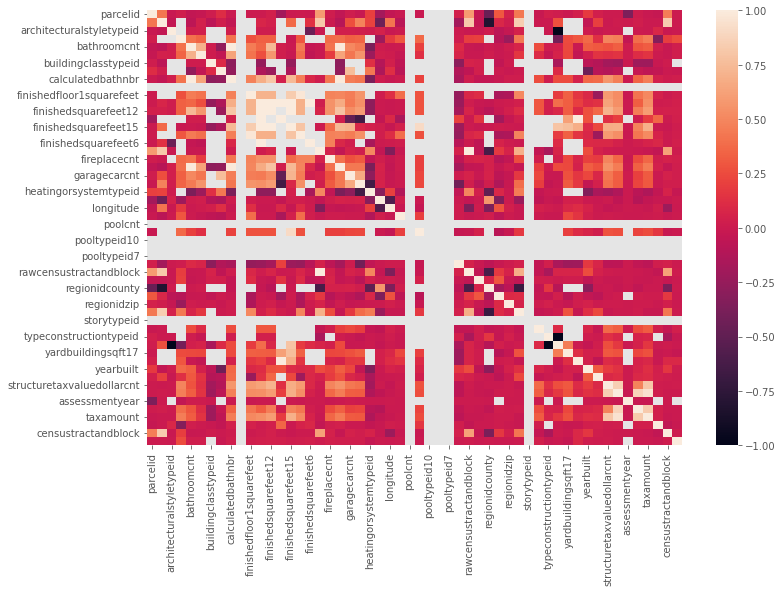

<Figure size 432x288 with 0 Axes>

In [28]:
def numeric_heatmap(df, col_type):
    plt.figure(figsize = (12,8))
    sns.heatmap(data=df.select_dtypes(include=col_type).corr())
    plt.show()
    plt.gcf().clear()
    pass

cols = ['float64','int64'] #choose the type you want to see
numeric_heatmap(data2016, cols)

### Step 1.4:  Identify Missing Values

Here, we identify feature with more than 90% missing values.
* If they are categorical, we need to carefully study them
* If they are numerical, it feels more reasonable to drop them. Else they will be in the way of the estimation.

Let's start by visualizing those features and then drop some of them.

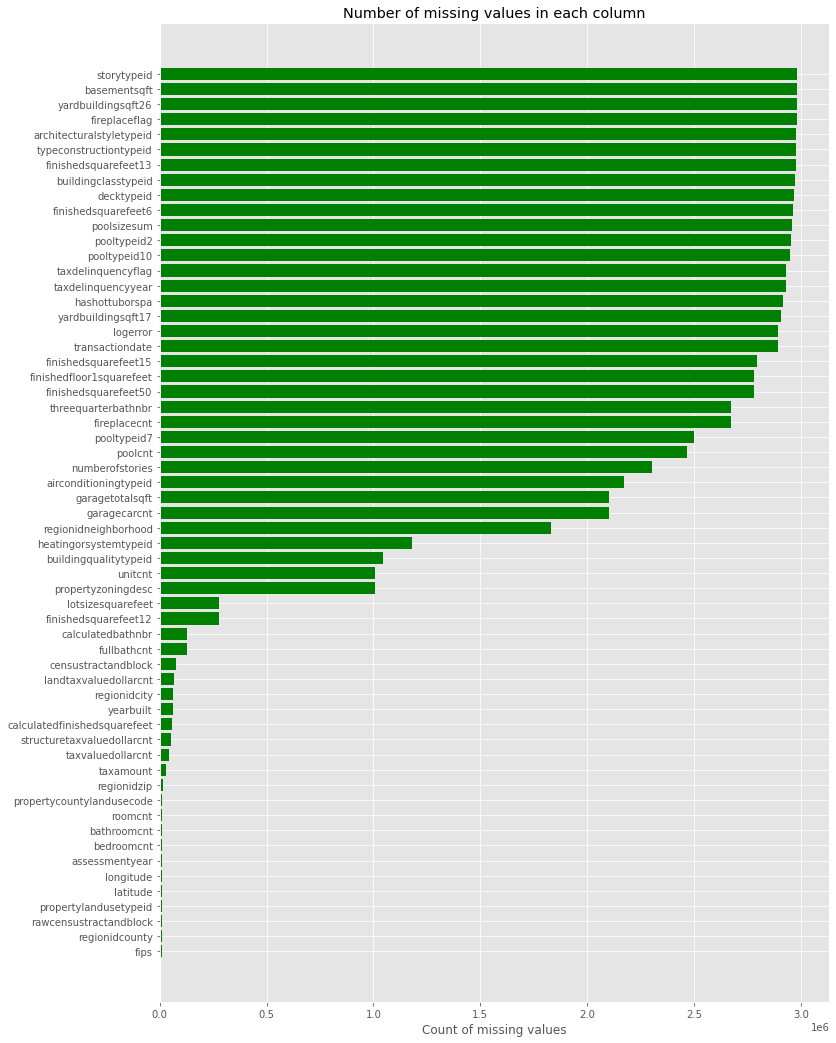

In [29]:
def missing_values_barplot(dataset):
    missing_df = dataset.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    # missing_df = dataset.isnull().sum(axis = 0) * 100 / len(dataset)
    missing_df = missing_df.sort_values(by='missing_count')

    ind = np.arange(missing_df.shape[0])
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,18))
    rects = ax.barh(ind, missing_df.missing_count.values, color='green')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    plt.show()
    pass

missing_values_barplot(data2016)

In [ ]:
#missing_values_barplot(data2017)

In [30]:
missing_ratio = data2016.isna().sum().sort_values(ascending = False)/len(data2016)
missing_ratio

storytypeid                     0.999456
basementsqft                    0.999455
yardbuildingsqft26              0.999113
fireplaceflag                   0.998270
architecturalstyletypeid        0.997969
typeconstructiontypeid          0.997740
finishedsquarefeet13            0.997430
buildingclasstypeid             0.995770
decktypeid                      0.994273
finishedsquarefeet6             0.992630
poolsizesum                     0.990633
pooltypeid2                     0.989256
pooltypeid10                    0.987626
taxdelinquencyflag              0.981084
taxdelinquencyyear              0.981084
hashottuborspa                  0.976882
yardbuildingsqft17              0.973083
logerror                        0.969761
transactiondate                 0.969761
finishedsquarefeet15            0.936085
finishedfloor1squarefeet        0.932094
finishedsquarefeet50            0.932094
threequarterbathnbr             0.895609
fireplacecnt                    0.895273
pooltypeid7     

We understand now that we have three kinds of problems here:
* Missing more than 89%
    * Probably best to drop, unless they are categorical
* Missing more than 40%
    * Could be time for some feature engineering 
    * Can be filled artificially
* Missing 10% or less
    * Can be filled artificially

The first thing to is to drop some data, which might be in our way to predict the logerror. Too many feature become difficult to handle.

##### Removing features that miss 89% of data or more

In [31]:
to_drop = missing_ratio[missing_ratio>=0.89].index.tolist()
data2016[to_drop].dtypes

storytypeid                 float64
basementsqft                float64
yardbuildingsqft26          float64
fireplaceflag                object
architecturalstyletypeid    float64
typeconstructiontypeid      float64
finishedsquarefeet13        float64
buildingclasstypeid         float64
decktypeid                  float64
finishedsquarefeet6         float64
poolsizesum                 float64
pooltypeid2                 float64
pooltypeid10                float64
taxdelinquencyflag           object
taxdelinquencyyear          float64
hashottuborspa               object
yardbuildingsqft17          float64
logerror                    float64
transactiondate              object
finishedsquarefeet15        float64
finishedfloor1squarefeet    float64
finishedsquarefeet50        float64
threequarterbathnbr         float64
fireplacecnt                float64
dtype: object

We will follow the strategy as stated before for every object present here, apart from `taxdelinquencyflag` which needs to be encoded.

NA values in each variable means that there is no fireplace/hot tub(spa) and property taxes for this parcel are not past due as of 2015. That is, NA is **unique category** in those variables.

Just to be sure, let's plot a heat map to see if there is a pattern we can exploit!

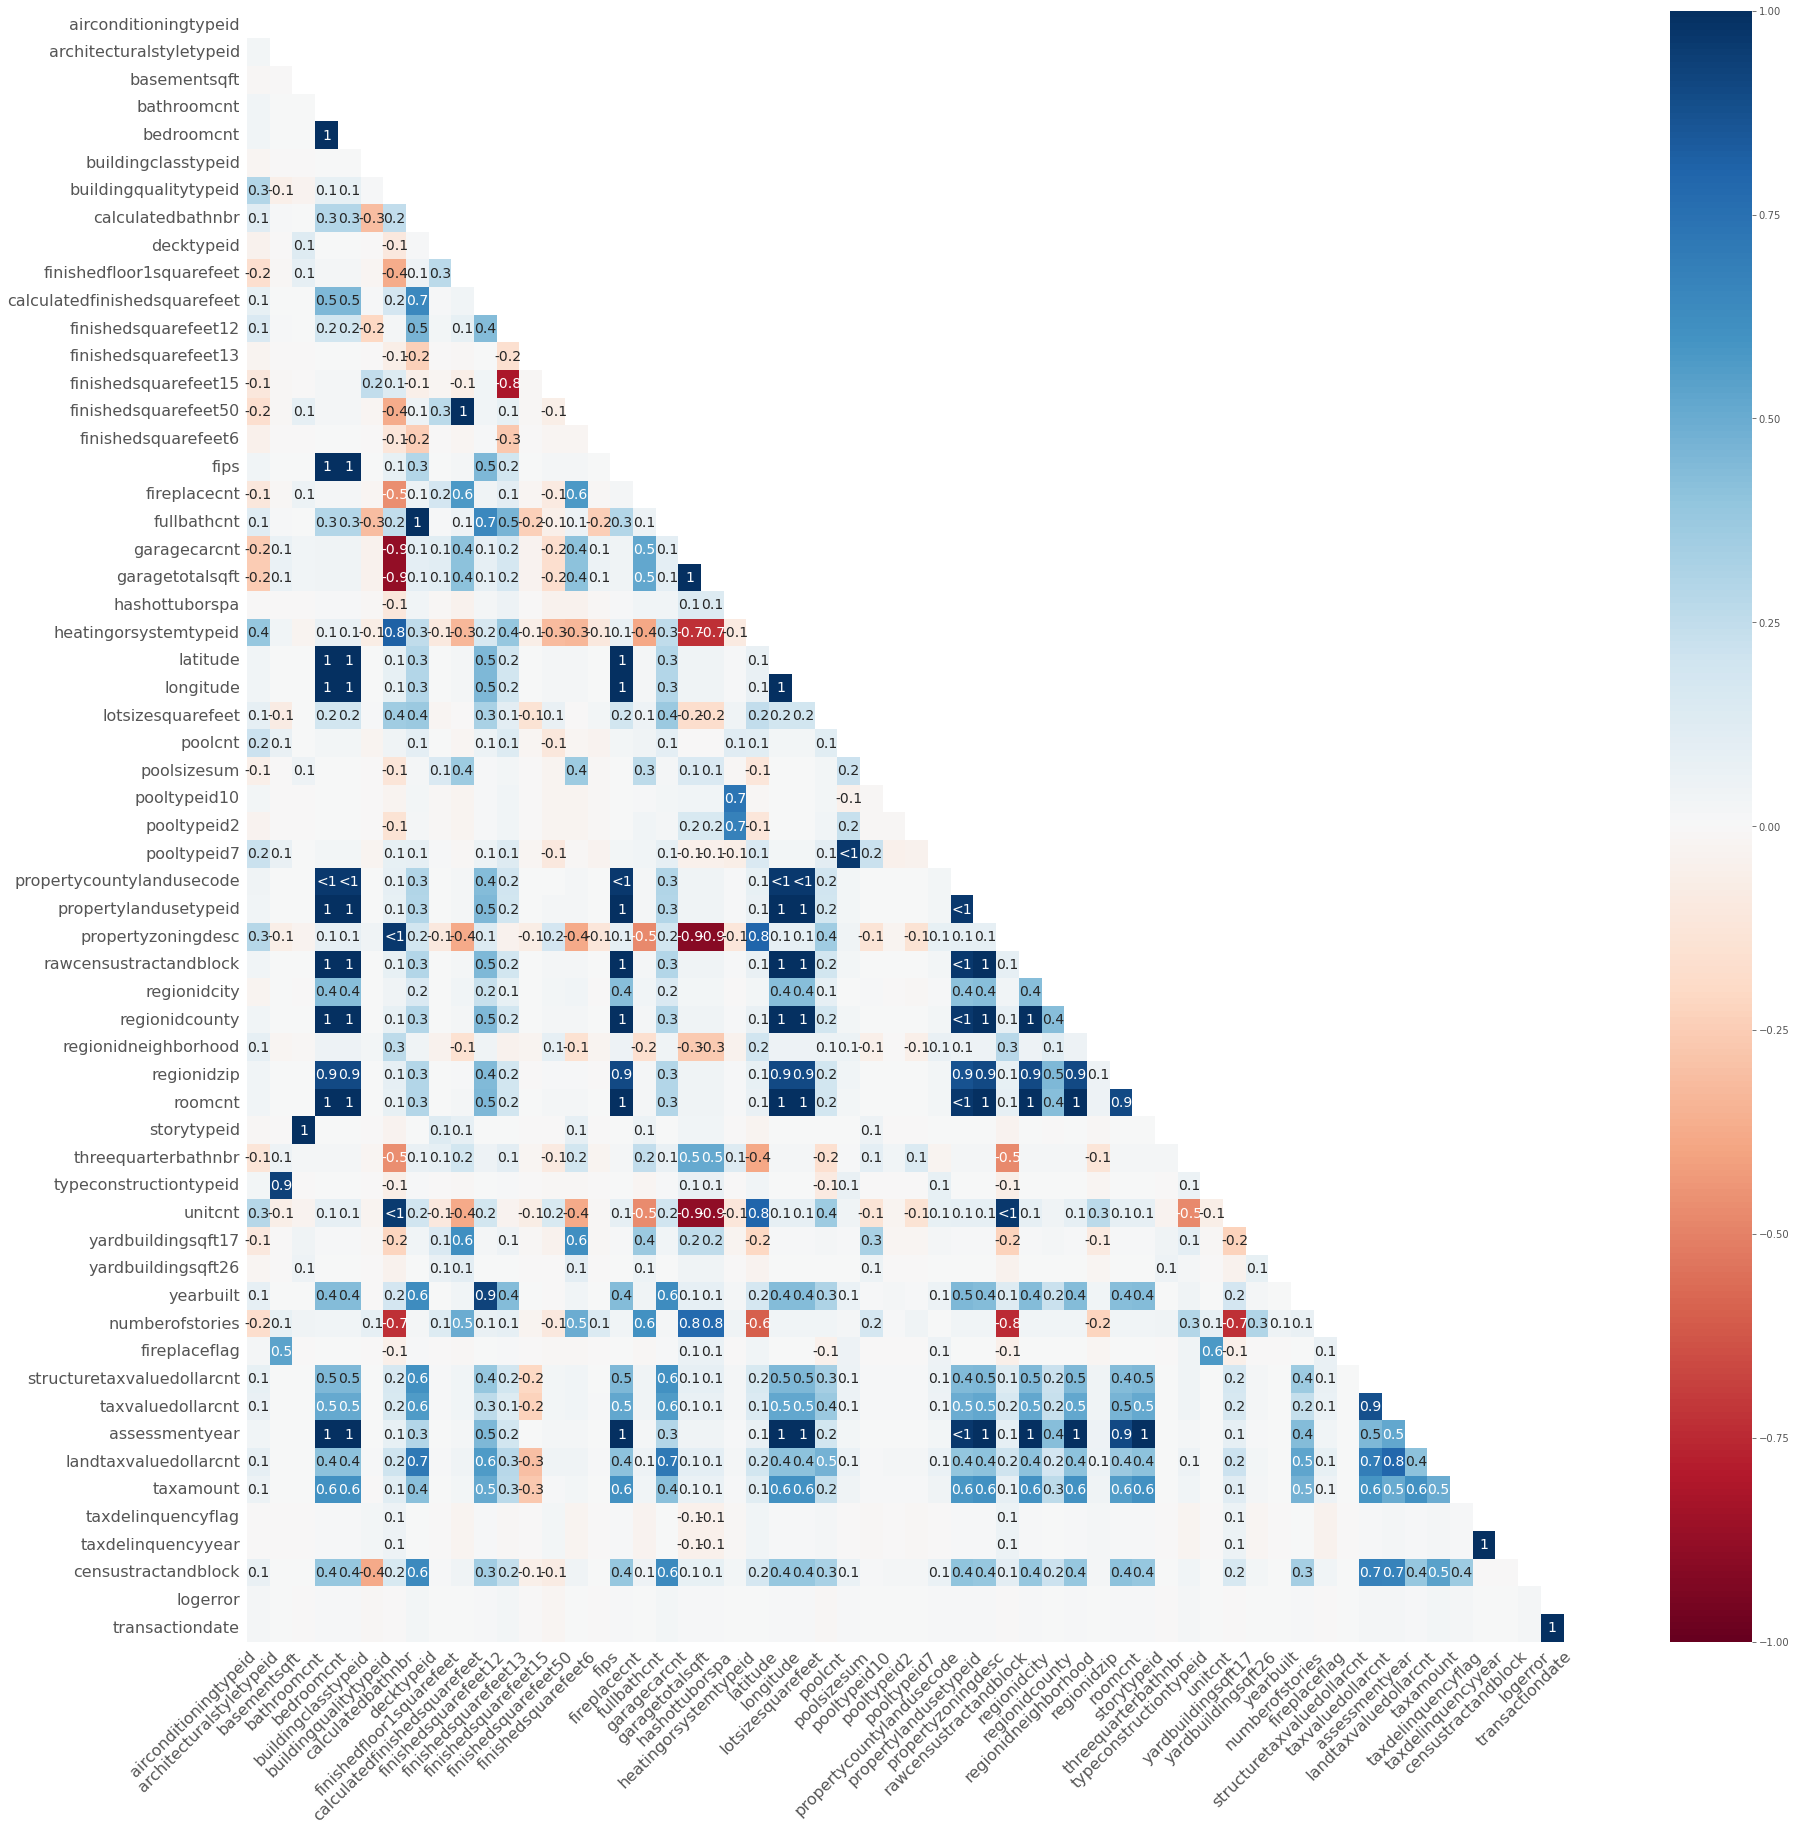

In [32]:
def missing_values_heatmap(dataset):
    missingValueColumns = dataset.columns[dataset.isnull().any()].tolist()
    msno.heatmap(dataset[missingValueColumns],figsize=(30,30))
    pass

missing_values_heatmap(data2016)

In [ ]:
# missing_values_heatmap(data2017)

We can see that some feature that are correlated, also are very redundant!

By looking at the claims description they represent very similair pieces of information (the area of the property) lets pick the one with the fewest number of missing values and drop the rest. 

### Step 2.2: LogError Outliers

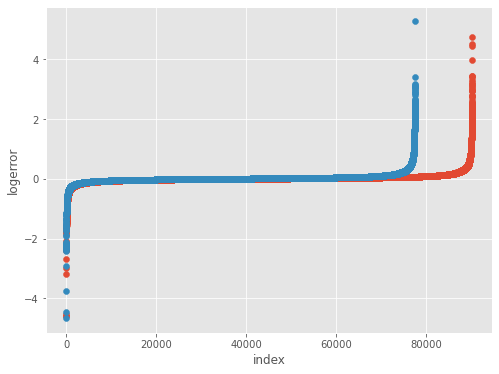

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(range(data2016.shape[0]), np.sort(data2016.logerror.values))
plt.scatter(range(data2017.shape[0]), np.sort(data2017.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

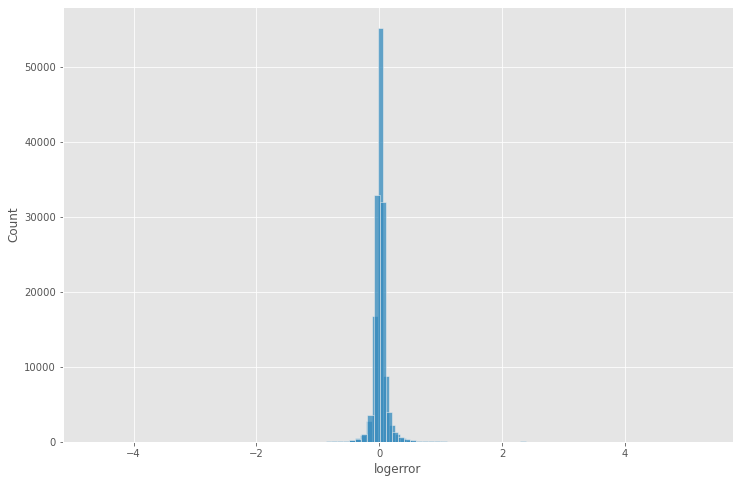

In [34]:
plt.figure(figsize=(12,8))
sns.histplot(data2016.logerror.values, bins=100, kde=False)
sns.histplot(data2017.logerror.values, bins=100, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

### Step 2.3: Transaction Date 

### Step 2.5: Correlation

In [35]:
numeric_heatmap(data2017, numerics)

NameError: name 'numerics' is not defined

## Step 3: Cleaning and Feature Engineering

We are going to create additional features to better direct our predictions.

#### A feature problem

Some of these columns are not useful for our purpose, this is why after an extensive research we understood the main driving factors for house prices:
1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. The local market and economic change
8. Mortgage interest rate

However, we do not have data for each one of those points and most of them are hard to represent in the way the datasets are given to us (even if wanted to add some features of our own).

We have to face some difficult decisions now, which will mainly concern
* Type Conversion
* Rescaling
* Dropping Values
    * Outliers
    * Empty Columns
* Artificial Filling (if over 60%)

### Step 3.1:  Additional features related to the property

In [36]:
for c in properties.columns:
    properties[c]=properties[c].fillna(-1)
    if properties[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties[c].values))
        properties[c] = lbl.transform(list(properties[c].values))

df_train = train.merge(properties, how='left', on='parcelid')

NameError: name 'properties' is not defined

In [42]:
#life of property
df_train['N-life'] = 2022 - df_train['yearbuilt']

#error in calculation of the finished living area of home
df_train['N-LivingAreaError'] = df_train['calculatedfinishedsquarefeet']/df_train['finishedsquarefeet12']

#proportion of living area
df_train['N-LivingAreaProp'] = df_train['calculatedfinishedsquarefeet']/df_train['lotsizesquarefeet']
df_train['N-LivingAreaProp2'] = df_train['finishedsquarefeet12']/df_train['finishedsquarefeet15']

#Amout of extra space
df_train['N-ExtraSpace'] = df_train['lotsizesquarefeet'] - df_train['calculatedfinishedsquarefeet'] 
df_train['N-ExtraSpace-2'] = df_train['finishedsquarefeet15'] - df_train['finishedsquarefeet12'] 

#Total number of rooms
df_train['N-TotalRooms'] = df_train['bathroomcnt']*df_train['bedroomcnt']

#Average room size
df_train['N-AvRoomSize'] = df_train['calculatedfinishedsquarefeet']/df_train['roomcnt'] 

# Number of Extra rooms
df_train['N-ExtraRooms'] = df_train['roomcnt'] - df_train['N-TotalRooms'] 

#Ratio of the built structure value to land area
df_train['N-ValueProp'] = df_train['structuretaxvaluedollarcnt']/df_train['landtaxvaluedollarcnt']

#Does property have a garage, pool or hot tub and AC?
df_train['N-GarPoolAC'] = ((df_train['garagecarcnt']>0) & (df_train['pooltypeid10']>0) & (df_train['airconditioningtypeid']!=5))*1 

df_train["N-location"] = df_train["latitude"] + df_train["longitude"]
df_train["N-location-2"] = df_train["latitude"]*df_train["longitude"]
df_train["N-location-2round"] = df_train["N-location-2"].round(-4)

df_train["N-latitude-round"] = df_train["latitude"].round(-4)
df_train["N-longitude-round"] = df_train["longitude"].round(-4)

#### Step 3.1.2:  Additional features based off the tax related variables

In [43]:
#Ratio of tax of property over parcel
df_train['N-ValueRatio'] = df_train['taxvaluedollarcnt']/df_train['taxamount']

#TotalTaxScore
df_train['N-TaxScore'] = df_train['taxvaluedollarcnt']*df_train['taxamount']

#polnomials of tax delinquency year
df_train["N-taxdelinquencyyear-2"] = df_train["taxdelinquencyyear"] ** 2
df_train["N-taxdelinquencyyear-3"] = df_train["taxdelinquencyyear"] ** 3

#Length of time since unpaid taxes
df_train['N-life'] = 2018 - df_train['taxdelinquencyyear']

#### Step 3.1.3: Other features based off the location

In [44]:
#Number of properties in the zip
zip_count = df_train['regionidzip'].value_counts().to_dict()
df_train['N-zip_count'] = df_train['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = df_train['regionidcity'].value_counts().to_dict()
df_train['N-city_count'] = df_train['regionidcity'].map(city_count)

#Number of properties in the city
region_count = df_train['regionidcounty'].value_counts().to_dict()
df_train['N-county_count'] = df_train['regionidcounty'].map(city_count)

#### Step 3.1.4: Additional variables which are simplification of some of the other variables

In [45]:
#Indicator whether it has AC or not
df_train['N-ACInd'] = (df_train['airconditioningtypeid']!=5)*1

#Indicator whether it has Heating or not 
df_train['N-HeatInd'] = (df_train['heatingorsystemtypeid']!=13)*1

#There's 25 different property uses - let's compress them down to 4 categories
df_train['N-PropType'] = df_train.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 291 : "Not Built" })

#### Step 3.1.5: Extra
One of the EDA kernels indicated that structuretaxvaluedollarcnt was one of the most important features. 
So let's create some additional variables on that.

In [46]:
#polnomials of the variable
df_train["N-structuretaxvaluedollarcnt-2"] = df_train["structuretaxvaluedollarcnt"] ** 2
df_train["N-structuretaxvaluedollarcnt-3"] = df_train["structuretaxvaluedollarcnt"] ** 3

#Average structuretaxvaluedollarcnt by city
group = df_train.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
df_train['N-Avg-structuretaxvaluedollarcnt'] = df_train['regionidcity'].map(group)

#Deviation away from average
df_train['N-Dev-structuretaxvaluedollarcnt'] = abs((df_train['structuretaxvaluedollarcnt'] - df_train['N-Avg-structuretaxvaluedollarcnt']))/df_train['N-Avg-structuretaxvaluedollarcnt']

### Step 3.2: Asserting feature importance
Lets use XGBoost to assess importance

In [47]:
train_y = df_train['logerror'].values
df_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
feat_names = df_train.columns.values

for c in df_train.columns:
    if df_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_train, train_y, feature_names=df_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

XGBoostError: [19:37:06] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/data/data.cc:1163: Check failed: valid: Input data contains `inf` or `nan`

In [48]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sns.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")

NameError: name 'model' is not defined

### Step 3.3 DataType conversion

In [ ]:
#### Step 3.3.1 Sales date conversion

In [ ]:
#### Step 3.3.2 DataType 

### Step 2.5: Data Cleaning
We need to identify
- Missing data
- Unhelpful features
- Non-numeric data
- Data that needs to be rescaled 

We need to plan
- Featuring engineering
- How to adapt/transform the data

---

To deal with Missing Data:

1st Method: Drop Missing Data
- a. Drop the whole row OR 
- b. Drop the whole column (This should be used ONLY if most entries are empty in your column)

2nd Method: Replace data 
- a. Replace it by mean OR
- b. Replace it by frequency (mode) OR 
- c. Replace it based on other functions

## Step 4: Development and Modeling
This step involves presenting
the dataset to the target audience in the form of graphs, summary tables, maps,
and diagrams.

### Step 4.1: Focus on logerror

In [ ]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values)) 
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))
        
train_y = mergedFilterd.logerror.values
train_X = mergedFilterd.drop(["parcelid", "transactiondate", "logerror"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

In [ ]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")

In [ ]:
### 4.2.1: TP Correlation

In [ ]:
topFeatures = features["features"].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

### 4.3: Multicollineraity analysis
In statistics, multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation, the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif


numericalCol = []
for f in merged.columns:
    #print (f)
    if merged[f].dtype!='object' and f not in ["parcelid", "transactiondate", "logerror"]:
        numericalCol.append(f)
mergedFilterd = merged[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sn.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h",color="#34495e")
sn.barplot(data=variablesWithMC.head(5),x="vifScore",y="variables",ax=ax2,orient="h",color="#34495e")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

NameError: name 'merged' is not defined

### Step 4.2 Top Features Selection

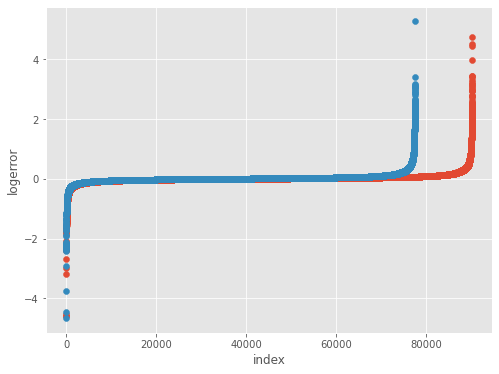

In [54]:
# Target variable for this competition is "logerror" field. 
# So let us do some analysis on this field first.

plt.figure(figsize=(8,6))
plt.scatter(range(data2016.shape[0]), np.sort(data2016.logerror.values))
plt.scatter(range(data2017.shape[0]), np.sort(data2017.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [55]:
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
merged['logerror'].ix[merged['logerror']>ulimit] = ulimit
merged['logerror'].ix[merged['logerror']<llimit] = llimit

fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.distplot(merged.logerror.values, bins=50,kde=False,color="#34495e",ax=ax)
ax.set(xlabel='logerror', ylabel='VIF Score',title="Distribution Of Dependent Variable")

NameError: name 'merged' is not defined

## Step 5: Cross Validation & Export

### Cross Validation
The threat of overfitting is always behind the corner. 

Overfitting is the low predictive power of the model, caused by the use of the same dataset for the training phase and the testing phase. Since the goal of the model is to "adapt" to the data on which it trains on, testing its accuracy on the same dataset would lead to some unaccurate results.

For this reason, we adopted the cross validation, which is a technique that prevents this phenomenon. 

We chose to split the dataset using the k-fold algorithm, by using the library provided by [Scikitlearn](https://https://scikit-learn.org/stable/modules/cross_validation.html).

This method consist in splitting the dataset in k groups (the "folds") and keeping one out as the testing set. This procedure is repeated for each one of the folds, in order to minimize the chances of overfitting.

Since we dispose of two main datasets, one for the year 2016 and one for the year 2017, we will apply the k-fold algorithm on both of them, and cross the resulting folds to maximize the randomness of the test.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold()

df_train_folded16, df_test_folded16 = [], []
df_train_folded17, df_test_folded17 = [], []


for train_index, test_index in kf.split(df_train16):
  df_train_folded16.append(df_train16[train_index])
  df_test_folded16.append(df_train16[train_test])

for train_index, test_index in kf.split(df_train17):
  df_train_folded17.append(df_train17[train_index])
  df_test_folded17.append(df_train17[train_test])


### Exporting the cleaned dataset

The following snippet will export the cleaned dataset in a series of file containing the testing and training dataset.



In [ ]:
#2016 dataset
i = 0
for ds in df_train_folded16:
  i += 1
  ds.to_csv(f"Data/train_dataset_2016_{i}")

i = 0
for ds in df_test_folded16:
  i += 1
  ds.to_csv(f"Data/test_dataset_2016_{i}")


In [ ]:
#2017 dataset
i = 0
for ds in df_train_folded17:
  i += 1
  ds.to_csv(f"Data/train_dataset_2017_{i}")

i = 0
for ds in df_test_folded17:
  i += 1
  ds.to_csv(f"Data/test_dataset_2017_{i}")


##### Credits
Credits go to: 
[Simple Exploration Notebook](https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-zillow-prize)
[Zillow analysis with EDAüè†](https://www.kaggle.com/code/hyewon328/zillow-analysis-with-eda)
[Zillow EDA On Missing Values & Multicollinearity](https://www.kaggle.com/code/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity)
[Creating Additional Features](https://www.kaggle.com/code/nikunjm88/creating-additional-features)
[Simple EDA Geo Data & Time Series](https://www.kaggle.com/code/kueipo/simple-eda-geo-data-time-series)
[Carefully dealing with missing values](https://www.kaggle.com/code/nikunjm88/carefully-dealing-with-missing-values)